In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '10000', 
                               '--g-rep-dim', '50',
                               '--k-dim', '50',
                               '--data-dir', './retina.h5ad',
                               '--model-name', 'retina_model.cpt',
                               '--exp-name', 'CohAE_retina',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', 'SU',
                               '--ld_nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'false',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'Annotation',
                               '--scv_n_jobs', '10',
                               '--v_rg_wt', '0.01' # with low-dimensional velocity constraints, 
                                                   # 1) project a velocity matrix (e.g., by scvelo stochastic mode) 
                                                   # into low-dim space, which was described in
                                                   # our paper https://www.biorxiv.org/content/10.1101/2021.03.19.436127v1.full
                                                   # 2) using low-dim S and U to fit V in the low-dim space using steady-state model
                                                   # make loss to constrain the projected and newly estimated Vs to be similar
                                                   # we currently use smoothl1loss.
                                                   # This parameter weighs this constrain loss.
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir='./retina.h5ad', device='cuda:2', exp_name='CohAE_retina', fit_offset_pred=False, fit_offset_train=False, g_rep_dim=50, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=50, ld_adata='projection.h5', ld_nb_g_src='SU', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list=None, model_name='retina_model.cpt', n_conn_nb=30, n_epochs=10000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.01, vis_key='X_umap', vis_type_col='Annotation', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("Progenitor", "Neuroblast"), 
    ("Neuroblast", "AC/HC"), 
    ("Neuroblast", "RGC"), 
    ("Neuroblast", "PR"), 
    ]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.73 0.27]
AnnData object with n_obs × n_vars = 2726 × 2000
    obs: 'Clusters', 'Annotation', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'Annotation_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/2726 [00:00<?, ?cells/s]

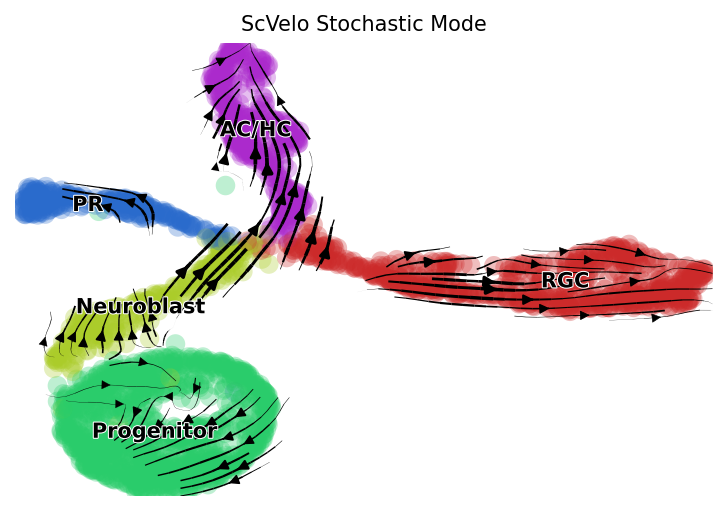

# Cross-Boundary Transition Score (A->B)
{('Progenitor', 'Neuroblast'): 0.045441903, ('Neuroblast', 'AC/HC'): 0.151623, ('Neuroblast', 'RGC'): 0.1582767, ('Neuroblast', 'PR'): 0.10917357}
Total Mean: 0.11612879484891891
# Cross-Boundary Velocity Coherence (A->B)
{('Progenitor', 'Neuroblast'): 0.8713295, ('Neuroblast', 'AC/HC'): 0.8535699, ('Neuroblast', 'RGC'): 0.88444084, ('Neuroblast', 'PR'): 0.825017}
Total Mean: 0.8585892915725708
# Cross-Boundary Direction Correctness (A->B)
{('Progenitor', 'Neuroblast'): -0.40912843872713744, ('Neuroblast', 'AC/HC'): 0.5743124758184602, ('Neuroblast', 'RGC'): 0.5206315127372094, ('Neuroblast', 'PR'): 0.2318413322522433}
Total Mean: 0.2294142205201939
# In-cluster Coherence
{'AC/HC': 0.91660905, 'Neuroblast': 0.9200961, 'PR': 0.88599855, 'Progenitor': 0.9217777, 'RGC': 0.9340173}
Total Mean: 0.9156997799873352
# In-cluster Confidence
{'AC/HC': 0.9151738224499816, 'Neuroblast': 0.9272633762035555, 'PR': 0.8839460564958446, 'Progenitor': 0.952487183

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=150, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Loss: 611013.687500: 100%|██████████| 10000/10000 [11:45<00:00, 14.18it/s] 


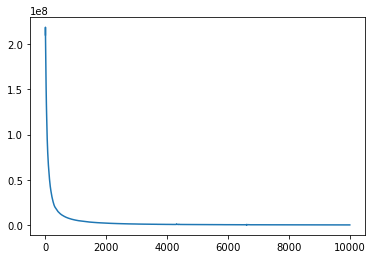

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/2726 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_retina_pojection.png


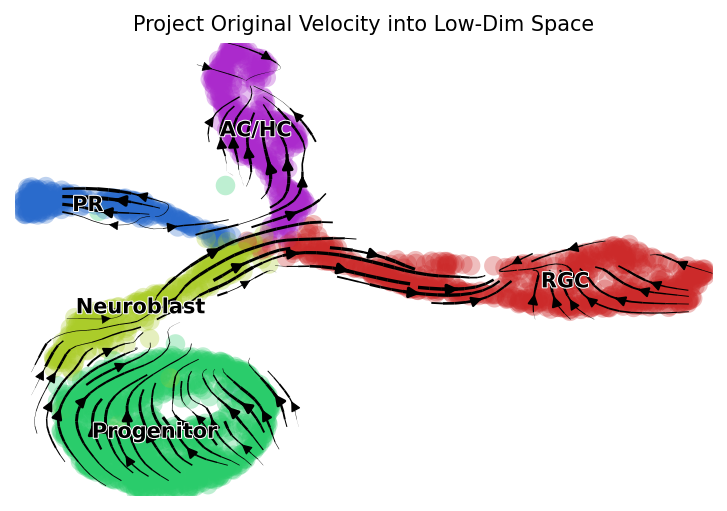

# Cross-Boundary Transition Score (A->B)
{('Progenitor', 'Neuroblast'): 0.22829875, ('Neuroblast', 'AC/HC'): 0.41756755, ('Neuroblast', 'RGC'): 0.45476052, ('Neuroblast', 'PR'): 0.30277517}
Total Mean: 0.35085049271583557
# Cross-Boundary Velocity Coherence (A->B)
{('Progenitor', 'Neuroblast'): 0.9037972, ('Neuroblast', 'AC/HC'): 0.9431031, ('Neuroblast', 'RGC'): 0.9286802, ('Neuroblast', 'PR'): 0.9342001}
Total Mean: 0.927445113658905
# Cross-Boundary Direction Correctness (A->B)
{('Progenitor', 'Neuroblast'): 0.6610741194614639, ('Neuroblast', 'AC/HC'): 0.8547074301711928, ('Neuroblast', 'RGC'): 0.760587930733382, ('Neuroblast', 'PR'): 0.15164104127375272}
Total Mean: 0.6070026304099478
# In-cluster Coherence
{'AC/HC': 0.9555428, 'Neuroblast': 0.9272682, 'PR': 0.9566191, 'Progenitor': 0.9394191, 'RGC': 0.9554452}
Total Mean: 0.9468588829040527
# In-cluster Confidence
{'AC/HC': 0.9507138363230939, 'Neuroblast': 0.9187675775254814, 'PR': 0.9528616789713907, 'Progenitor': 0.937033122810

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis=args.vis_key, color=args.vis_type_col,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=150,
                                    save='retina_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.73 0.27]


  0%|          | 0/827 [00:00<?, ?gene/s]

  0%|          | 0/2726 [00:00<?, ?cells/s]

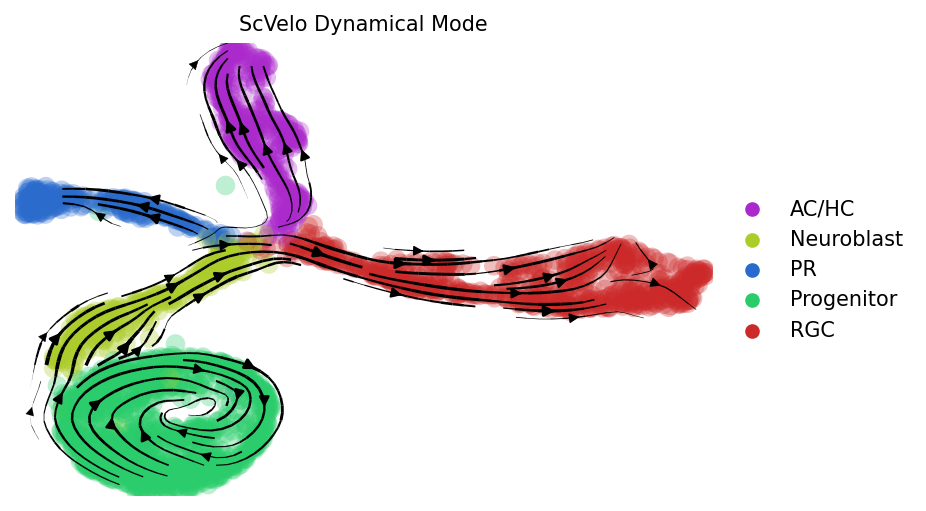

# Cross-Boundary Transition Score (A->B)
{('Progenitor', 'Neuroblast'): 0.18299975, ('Neuroblast', 'AC/HC'): 0.3490154, ('Neuroblast', 'RGC'): 0.46213865, ('Neuroblast', 'PR'): 0.13937818}
Total Mean: 0.28338298201560974
# Cross-Boundary Velocity Coherence (A->B)
{('Progenitor', 'Neuroblast'): 0.6675449541893601, ('Neuroblast', 'AC/HC'): 0.5055589165287258, ('Neuroblast', 'RGC'): 0.6316754757808929, ('Neuroblast', 'PR'): 0.7141833388842417}
Total Mean: 0.6297406713458051
# Cross-Boundary Direction Correctness (A->B)
{('Progenitor', 'Neuroblast'): 0.44581341085999054, ('Neuroblast', 'AC/HC'): 0.7628520820543901, ('Neuroblast', 'RGC'): 0.8915728071492771, ('Neuroblast', 'PR'): -0.1405671000142231}
Total Mean: 0.48991780001235874
# In-cluster Coherence
{'AC/HC': 0.8772363666999371, 'Neuroblast': 0.8642802598436602, 'PR': 0.7916543840805668, 'Progenitor': 0.7814499718166346, 'RGC': 0.9140786190385313}
Total Mean: 0.845739920295866
# In-cluster Confidence
{'AC/HC': 0.8724419378689628, 'Neur

In [10]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)